## Semi-gradient SARSA($\lambda$) Control

In [2]:
import gymnasium as gym
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Image

%matplotlib inline

print("imports done!")

imports done!


In [3]:
class SARSA_Lambda:
    """Semi-gradient SARSA(λ) Control Algorithm with Eligibility Traces."""
    
    def __init__(self, get_possible_actions, strategy, lambda_=0.9, epsilon=1, alpha=0.1, gamma=0.99):
        self.Q = defaultdict(lambda: defaultdict(lambda: 0))  # Q-table
        self.eligibility_traces = defaultdict(lambda: defaultdict(lambda: 0))  # Eligibility traces
        self.get_possible_actions = get_possible_actions
        self.strategy = strategy
        self.lambda_ = lambda_  # Trace decay parameter
        self.epsilon = epsilon  # Exploration rate
        self.alpha = alpha      # Learning rate
        self.gamma = gamma      # Discount factor

    def get_Q(self, state, action):
        return self.Q[state][action]

    def set_Q(self, state, action, value):
        self.Q[state][action] = value

    def update(self, state, action, reward, next_state, next_action, done):
        """
        Updates Q-values using eligibility traces.
        """
        td_error = reward + self.gamma * self.get_Q(next_state, next_action) * (not done) - self.get_Q(state, action)
        
        # Update eligibility traces
        for s in self.eligibility_traces:
            for a in self.eligibility_traces[s]:
                self.eligibility_traces[s][a] *= self.gamma * self.lambda_
        self.eligibility_traces[state][action] += 1  # Increase trace for visited pair

        # Update Q-values for all state-action pairs
        for s in self.eligibility_traces:
            for a in self.eligibility_traces[s]:
                self.Q[s][a] += self.alpha * td_error * self.eligibility_traces[s][a]

        if done:
            self.eligibility_traces = defaultdict(lambda: defaultdict(lambda: 0))  # Reset traces at episode end

    def get_action(self, state):
        return self.strategy(self.epsilon, self.get_possible_actions, state, self.max_action)

    def max_action(self, state):
        """
        Selects the action with the highest Q-value.
        """
        actions = self.get_possible_actions(state)
        best_action = []
        best_q_value = float("-inf")
        for action in actions:
            q_value = self.get_Q(state, action)
            if q_value > best_q_value:
                best_action = [action]
                best_q_value = q_value
            elif q_value == best_q_value:
                best_action.append(action)
        return np.random.choice(best_action)


In [4]:
def epsilon_greedy_strategy(epsilon, get_possible_actions, state, max_action):
    """
    Epsilon-greedy strategy.

    Choose a random number in the interval [0, 1) with a uniform 
    probability distribution. Use np.random.random() to do this.

    If this random number is less than epsilon, return a random action.
    Otherwise, return the best action for the given state.
    """
    actions = get_possible_actions(state)
    if len(actions) == 0:
        return None
    random_number = np.random.random()
    if random_number < epsilon:
        # exploration
        return np.random.choice(actions)
    else:
        # exploitation
        return max_action(state)
    

In [5]:
def train_sarsa_lambda(env, agent, num_episodes=10_000, t_max=10_000, decay_rate=None):
    """
    Train an agent using the Semi-gradient SARSA(λ) algorithm.
    """
    episode_rewards = []
    for episode in tqdm(range(num_episodes)):
        G = 0
        state, _ = env.reset()
        action = agent.get_action(state)
        
        for t in range(t_max):
            next_state, reward, done, trunc, _ = env.step(action)
            next_action = agent.get_action(next_state)
            agent.update(state, action, reward, next_state, next_action, done)
            G += reward

            if done or trunc:
                episode_rewards.append(G)
                if decay_rate is not None:
                    agent.epsilon *= decay_rate
                break
            
            state = next_state
            action = next_action

    return np.array(episode_rewards)

In [6]:
def plot_rewards(env_name, rewards, label):
    plt.title(f"Env: {env_name}  Mean Reward: {np.mean(rewards[-20:]):.1f}")
    plt.plot(rewards, label=label)
    plt.grid()
    plt.legend()
    plt.show()


### Trying out Semi-gradient SARSA(λ) on Cliff Walking environment

In [7]:
Image(url="https://gymnasium.farama.org/_images/cliff_walking.gif")

In [8]:
# create Cliff Walking environment
cw_env = gym.make("CliffWalking-v0")

In [9]:
cw_env.reset()

(36, {'prob': 1})

In [10]:
cw_env.action_space.n

4

In [11]:
cw_env.observation_space.n

48

In [12]:
agent1 = SARSA_Lambda(
    get_possible_actions = lambda s : range(cw_env.action_space.n),
    strategy = epsilon_greedy_strategy,
    epsilon = 0.2,
    alpha = 0.25, 
    gamma = 0.99
)

rewards = train_sarsa_lambda(cw_env, agent1, num_episodes=5000, decay_rate=0.99)

  1%|          | 51/5000 [00:01<00:52, 93.55it/s]

100%|██████████| 5000/5000 [00:15<00:00, 331.96it/s]


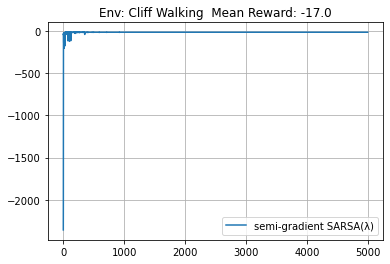

In [13]:
plot_rewards("Cliff Walking", rewards, "semi-gradient SARSA(λ)")

In [14]:
def fn():
    action_dict = {
        0: "UP",
        1: "RIGHT",
        2: "DOWN",
        3: "LEFT"
    }
    state, _ = cw_env.reset()
    print(f"state: {state}")
    while True:
        best_action = agent1.max_action(state)
        print(f"best_action: {action_dict[best_action]}")
        next_state, reward, done, trunc, _ = cw_env.step(best_action)
        if done or trunc:
            print(f"Terminal state reached.\nState: {next_state}")
            break
        state = next_state
        print(f"state: {state}")

fn()

state: 36
best_action: UP
state: 24
best_action: UP
state: 12
best_action: RIGHT
state: 13
best_action: RIGHT
state: 14
best_action: UP
state: 2
best_action: RIGHT
state: 3
best_action: RIGHT
state: 4
best_action: RIGHT
state: 5
best_action: RIGHT
state: 6
best_action: RIGHT
state: 7
best_action: RIGHT
state: 8
best_action: RIGHT
state: 9
best_action: RIGHT
state: 10
best_action: RIGHT
state: 11
best_action: DOWN
state: 23
best_action: DOWN
state: 35
best_action: DOWN
Terminal state reached.
State: 47
